In [1]:
%cd ..
%ls

/home/nas3_userJ/dmkim/OnlineTSAD
cfgs/         data/  Exp/   models/   plots/    test.py*   utils/  wandb/
checkpoints/  EDA/   logs/  outputs/  results/  train.py*  Vis/


In [2]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_anomaly

import warnings
from data.load_data import DataFactory
from Exp.ReconBaselines import *

from easydict import EasyDict as edict
import yaml
import re

warnings.filterwarnings("ignore")

In [3]:
# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})
cfg['dataset'] = 'SWaT'

In [4]:
args = prepare_arguments(cfg)
args.model.latent_dim = 128
args.window_size = 12
args.eval_batch_size = 1
args.dataset = "SWaT"
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-03-21 14:29:12,911] Configurations: {'exp_id': 'MLP_SWaT', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT', 'log_path': './logs/MLP_SWaT', 'output_path': './outputs/MLP_SWaT', 'plot_path': './plots/MLP_SWaT', 'result_path': './results/MLP_SWaT', 'thresholding': 'oracle', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}
[2023-03-21 14:29:12,912] Preparing SWaT dataset...
[2023-03-21 14:29:12,913] current location: /home/nas3_userJ/dmkim/OnlineTSAD
[2023-03-21 14:29:12,914] home dir: .
[2023-03-21 14:29:12,915] Preparing SWaT ...


{'exp_id': 'MLP_SWaT', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT', 'log_path': './logs/MLP_SWaT', 'output_path': './outputs/MLP_SWaT', 'plot_path': './plots/MLP_SWaT', 'result_path': './results/MLP_SWaT', 'thresholding': 'oracle', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}


[2023-03-21 14:29:21,400] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-03-21 14:29:21,533] Complete.
[2023-03-21 14:29:21,535] Preparing dataloader...
[2023-03-21 14:29:22,230] total train dataset- 7763, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-03-21 14:29:22,232] total test dataset- 37493, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-03-21 14:29:22,233] Complete.


(496800, 51) (496800,) (449916, 51) (449916,)


## Visualize

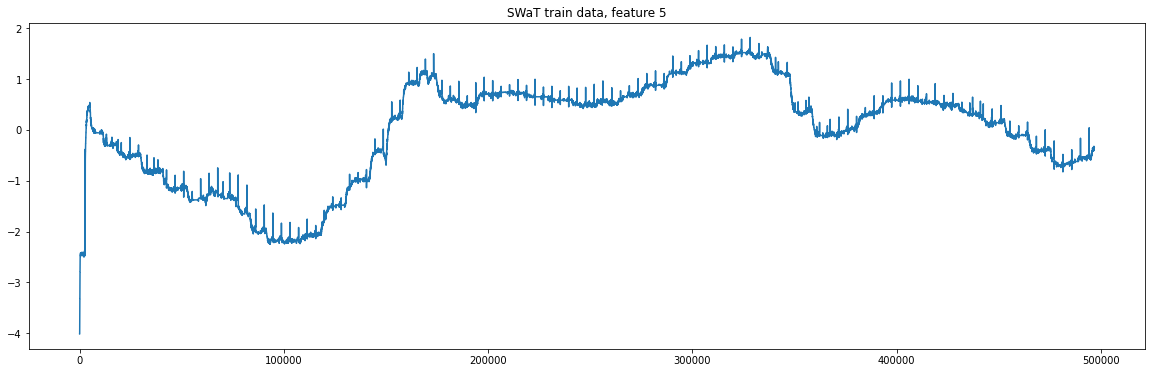

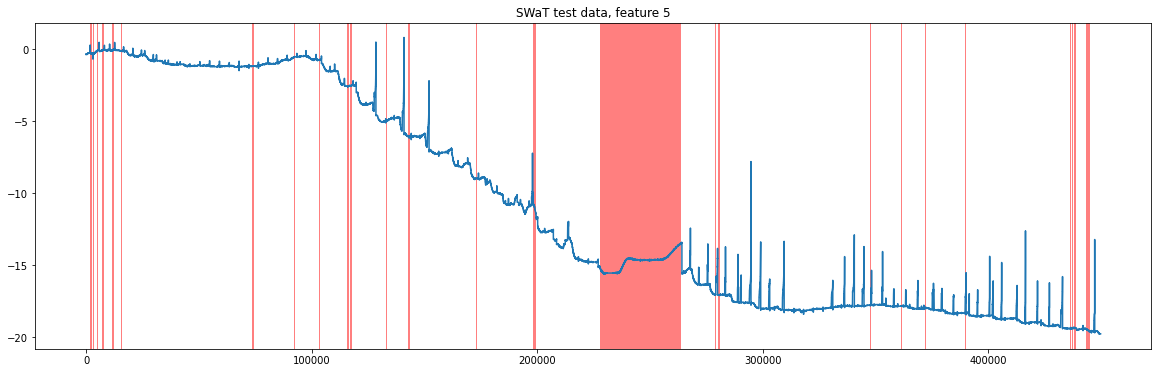

In [5]:
C = 5
dataset = "SWaT"
datafactory.visualize_dataset(train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y, dataset_name=dataset, feature_idx=C)

## Load Model

In [50]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

[2023-03-21 20:27:31,764] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict


In [51]:
next(iter(tester.model.parameters())).device, next(iter(tester.model.parameters())).requires_grad

(device(type='cuda', index=0), True)

## Training statistics

In [8]:
train_iterator = tqdm(
    tester.train_loader,
    total=len(tester.train_loader),
    desc="calculating reconstruction errors",
    leave=True
)

recon_errors = []
with torch.no_grad():
    for i, batch_data in enumerate(train_iterator):
        X = batch_data[0].to(args.device)
        B, L, C = X.shape
        Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
        recon_error = torch.nn.functional.mse_loss(Xhat, X, reduction='none')
        recon_errors.append(recon_error)

recon_errors = torch.cat(recon_errors, axis=0)

train_error_dist = recon_errors.mean(dim=(1, 2))

print(f"{recon_errors.shape}, {train_error_dist.shape}")

calculating reconstruction errors: 100%|██████████| 7763/7763 [00:12<00:00, 617.07it/s]

torch.Size([496789, 12, 51]), torch.Size([496789])


## Test: static threshold inference

In [9]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

anoscs_prev = []
Xhats_prev = []
with torch.no_grad():
    for i, batch_data in enumerate(eval_iterator):
        X, y = batch_data[0].to(args.device), batch_data[1].to(args.device)
        B, L, C = X.shape
        Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
        Xhats_prev.append(Xhat)        
        e = F.mse_loss(Xhat, X, reduction='none')
        anosc = e.mean(dim=2)
        anoscs_prev.append(anosc)

Xhats_prev = torch.cat(Xhats_prev, axis=0).detach().cpu().numpy()
anoscs_prev = torch.cat(anoscs_prev, axis=0).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [00:25<00:00, 1460.20it/s]


In [10]:
th_q95 = torch.quantile(train_error_dist, 0.95).item()
th_q99 = torch.quantile(train_error_dist, 0.99).item()
th_q100 = torch.max(train_error_dist).item()
th_best_static = tester.get_best_static_threshold(gt=test_y, anomaly_scores=anoscs_prev)
th_q95, th_q99, th_q100, th_best_static

[2023-03-21 14:30:04,357] Best threshold found at: 7.9125590324401855, with fpr: 0.007262250462902067, tpr: 0.6276198153304998
tn: 392461 fn: 20326
fp: 2871 tp: 34258


(0.009716848842799664, 0.04816127195954323, 6.910831451416016, 7.912559)

In [11]:
# 95
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q95))
# 99
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q99))
# 100
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q100))
# oracle
print(get_summary_stats(test_dataset.y, anoscs_prev > th_best_static))

{'Accuracy': 0.2798144542536829, 'Precision': 0.14097681744168383, 'Recall': 0.9691484684156529, 'F1': 0.24614783294518905, 'tn': 72993, 'fp': 322339, 'fn': 1684, 'tp': 52900}
{'Accuracy': 0.3467002729398377, 'Precision': 0.149155672823219, 'Recall': 0.932086325663198, 'F1': 0.2571597537428858, 'tn': 105109, 'fp': 290223, 'fn': 3707, 'tp': 50877}
{'Accuracy': 0.9476768996879418, 'Precision': 0.9136750086618161, 'Recall': 0.6280595046167375, 'F1': 0.7444112697464851, 'tn': 392093, 'fp': 3239, 'fn': 20302, 'tp': 34282}
{'Accuracy': 0.9484392642182097, 'Precision': 0.9226729153199742, 'Recall': 0.6276014949435732, 'F1': 0.7470560013956733, 'tn': 392461, 'fp': 2871, 'fn': 20327, 'tp': 34257}


## Stat Tracker

In [12]:
test_X.shape

(449916, 51)

In [13]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

from collections import deque

class GaussianTracker:
    def __init__(self, num_channels, capacity):
        self.C = num_channels
        self.capacity = capacity
        self.reset()
        
        
    def reset(self):
        self.mem = None
        self.mu = 0
        self.var = 0
        self.n = 0

        
    def __len__(self):
        return self.n
    
    
    def get_mu(self):
        return self.mu
    
    
    def get_var(self):
        return self.var
    
    
    def get_std(self):
        return torch.sqrt(self.var)
    
    def update(self, x):
        L, C = x.shape
        assert self.C == C
        q = L # number of new samples
        
        self.mem = x if self.n == 0 else torch.cat([self.mem, x])
        self.n = len(self.mem)
        
        if self.n > self.capacity:
            p = self.n-self.capacity
            self.mem = self.mem[p:,:]
            self.n -= p
        
        self.mu = self.mem.mean(dim=0)
        self.var = self.mem.var(dim=0)
    
    '''
    def update(self, x):
        # L, C
        L, C = x.shape
        assert self.C == C
        q = L # number of new samples

        # update gaussian statistics
        mu, var, n = self.mu, self.var, self.n # mu, var, num_samples so far
        mu_q, var_q = x.mean(dim=0), x.var(dim=0)
        if n == 0:
            self.mu, self.var = mu_q, var_q
            self.mem = x
        else:
            self.mu = (mu*n + mu_q*q) / (n+q)
            self.var = (n*(var+mu**2) + q*(var_q+mu_q**2)) / (n+q) - self.mu**2
            self.mem = torch.cat([self.mem, x])
        self.n += q
        
        # evict if full
        if self.n > self.capacity:
            import pdb;pdb.set_trace();
            self.evict(self.n-self.capacity)
        
        
    def evict(self, p):
        # evict p timesteps from the memory.
        n = self.n
        assert 0 <= p <= n
        if p == n: # corner case
            self.reset()
            return             
        
        Xp, Xn = self.mem[:p,:], self.mem[p:]
        
        # update gaussian statistics
        mu, var, n = self.mu, self.var, self.n # mu, var, num_samples so far
        mu_p, var_p = Xp.mean(0), Xp.var(0)
        
        self.mu = (mu*n - mu_p*p) / (n-p)
        self.var = (n*(var+mu**2)-p*(var_p+mu_p**2)) / (n-p) - self.mu**2
        self.mem = Xn
        self.n -= p
    
    '''
        
memory = GaussianTracker(num_channels=args.num_channels, capacity=86400)

Xs = []
Xmu, Xstd = [], []
with torch.no_grad():
    for i, batch_data in enumerate(eval_iterator):
        X, y = batch_data[0].to(args.device), batch_data[1].to(args.device)
        B, L, C = X.shape
        Xs.append(X)
        
        memory.update(X.reshape(B*L, C))
        mu, std = memory.get_mu(), memory.get_std()
        Xmu.append(mu)
        Xstd.append(std)    

calculating reconstruction errors: 100%|██████████| 37493/37493 [00:13<00:00, 2732.78it/s]


In [14]:
Xs = torch.cat(Xs).reshape(-1, args.num_channels)
Xmu = torch.stack(Xmu)
Xstd = torch.stack(Xstd)

In [15]:
Xs = Xs.detach().cpu().numpy()
Xmu = Xmu.detach().cpu().numpy()
Xstd = Xstd.detach().cpu().numpy()

In [16]:
Xmu = np.repeat(Xmu, args.window_size, axis=0)
Xstd = np.repeat(Xstd, args.window_size, axis=0)

In [17]:
Xmu.shape

(449916, 51)

In [ ]:
Xmu[:, c].shape

In [ ]:
for c in range(args.num_channels):
    plt.figure(figsize=(20, 6))
    plt.plot(Xs[:, c], label="value")
    plt.plot(Xmu[:, c], label="mean")
    plt.fill_between(
        range(len(Xmu)),
        Xmu[:, c]-1.96*Xstd[:, c], 
        Xmu[:, c]+1.96*Xstd[:, c], 
        alpha=0.3, 
        color="yellow"
    )

    plt.legend()
    plt.show()

## Value-based Pseudo-label guided Online Learning

In [28]:
class GaussianTracker:
    def __init__(self, num_channels, capacity):
        self.C = num_channels
        self.capacity = capacity
        self.reset()
        
        
    def reset(self):
        self.mem = None
        self.mu = 0
        self.var = 0
        self.n = 0

        
    def __len__(self):
        return self.n
    
    
    def get_mu(self):
        return self.mu
    
    
    def get_var(self):
        return self.var
    
    
    def get_std(self):
        return torch.sqrt(self.var)
    
    def update(self, x):
        L, C = x.shape
        assert self.C == C
        q = L # number of new samples
        
        self.mem = x if self.n == 0 else torch.cat([self.mem, x])
        self.n = len(self.mem)
        
        if self.n > self.capacity:
            p = self.n-self.capacity
            self.mem = self.mem[p:,:]
            self.n -= p
        
        self.mu = self.mem.mean(dim=0)
        self.var = self.mem.var(dim=0)

In [29]:
TIME_WINDOW = 86400
memory = GaussianTracker(num_channels=args.num_channels, capacity=TIME_WINDOW)
memory.update(torch.Tensor(train_X[-TIME_WINDOW:]).to(args.device))

In [30]:
print(len(memory))
print(memory.mu)
print(memory.var)

86400
tensor([ 3.9052e-03,  3.8739e-02,  4.1735e-03,  3.1205e-02,  0.0000e+00,
        -2.1683e-02, -3.4013e-02, -4.1864e-01,  2.4038e-02,  2.9625e-02,
         0.0000e+00,  0.0000e+00,  3.1420e-02,  0.0000e+00,  2.0908e-01,
         0.0000e+00,  1.5619e-02,  3.0139e-02,  7.4926e-02,  9.2865e-04,
         2.3252e-02, -1.6408e-03, -1.9117e-03, -6.3113e-02,  3.4747e-02,
         4.4437e-01, -1.0910e+00,  1.9371e-01,  1.1597e-01,  0.0000e+00,
         8.0340e-02,  0.0000e+00,  0.0000e+00,  8.0403e-02,  2.1291e-01,
        -1.0571e+00, -9.9677e-02,  1.2574e-02,  1.9782e-01,  2.7443e-01,
        -1.9572e-02,  1.9960e-07,  8.2246e-02,  0.0000e+00, -1.0938e-01,
        -1.1943e-01, -1.5762e-01, -1.5162e-03,  0.0000e+00, -1.2834e-03,
         0.0000e+00], device='cuda:0')
tensor([9.9532e-01, 8.0427e-01, 9.9655e-01, 9.6360e-01, 0.0000e+00, 1.9125e-01,
        1.2970e-01, 1.1501e-02, 9.5534e-01, 9.6556e-01, 0.0000e+00, 0.0000e+00,
        9.6371e-01, 0.0000e+00, 8.1547e-01, 0.0000e+00, 9.6888e-0

In [31]:
init_thr = torch.quantile(train_error_dist, 0.95).item()
thr = torch.tensor(init_thr, requires_grad=True)
thr

tensor(0.0097, requires_grad=True)

In [ ]:
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TH_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
anoscs=[]
thrs = []
preds = []
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    Xs.append(X)
    
    # infer
    B, L, C = X.shape
    Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
    Xhats.append(Xhat)
    
    e = F.mse_loss(Xhat, X, reduction='none')
    anosc = e.mean(dim=2)
    anoscs.append(anosc)
    thrs.append(thr.item())
    pred = (anosc > thr)
    preds.append(pred)
    
    # pseudo-label
    mu = memory.get_mu()
    std = memory.get_std() + 1e-03
    var = torch.diag(memory.get_var()) + 1e-03 * torch.eye(args.num_channels).to(args.device)
    
    dist = Normal(mu, std)
    mdist = MultivariateNormal(mu, var)
    
    phi_X = dist.cdf(X)
    phi_mask = (phi_X > 0.5)
    tail_prob = 2*((1-phi_X) * phi_mask + phi_X * ~phi_mask)
    new_normal_prob = 1-tail_prob
    
    mask = new_normal_prob > 0.05
    y_tilde = (1-tail_prob)*mask
    
    # update
    TH_optimizer.zero_grad()
    yhat = torch.sigmoid(anosc-thr)
    yhats.append(yhat)
    cls_loss = bce(yhat, y_tilde)
    recon_loss = (e*new_normal_prob).mean()
    loss = cls_loss + recon_loss
    loss.backward()
    TH_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()
#yhats = torch.cat(yhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(anoscs, axis=0).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

## Label

In [52]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

[2023-03-21 20:28:25,579] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict


In [53]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TT_optimizer = torch.optim.SGD([p for p in tester.model.parameters()], lr=lr)
TH_optimizer = torch.optim.SGD([thr], lr=lr)
bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
anoscs=[]
thrs = []
preds = []
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    Xs.append(X)
    
    # infer
    B, L, C = X.shape
    Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
    Xhats.append(Xhat)
    
    e = F.mse_loss(Xhat, X, reduction='none')
    anosc = e.mean(dim=2)
    anoscs.append(anosc)
    thrs.append(thr.item())
    
    ytilde = (anosc > thr).float().detach()
    preds.append(ytilde)
    
    # recon update
    TT_optimizer.zero_grad()
    recon_loss = (anosc*ytilde).mean()
    recon_loss.backward()
    TT_optimizer.step()

    # classifier loss
    TH_optimizer.zero_grad()
    Xhatp = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
    e = F.mse_loss(Xhatp, X, reduction='none')
    anosc = e.mean(dim=2)
    yhat = torch.sigmoid(anosc-thr)
    cls_loss = bce(yhat, ytilde)
    cls_loss.backward()
    TH_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()
#yhats = torch.cat(yhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(anoscs, axis=0).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [03:00<00:00, 207.31it/s]


In [54]:
print(test_y.shape, preds.shape)
get_summary_stats(test_y, preds)

(449916,) (449916,)


{'Accuracy': 0.12132042425697241,
 'Precision': 0.12132042425697241,
 'Recall': 1.0,
 'F1': 0.216388503468781,
 'tn': 0,
 'fp': 395332,
 'fn': 0,
 'tp': 54584}

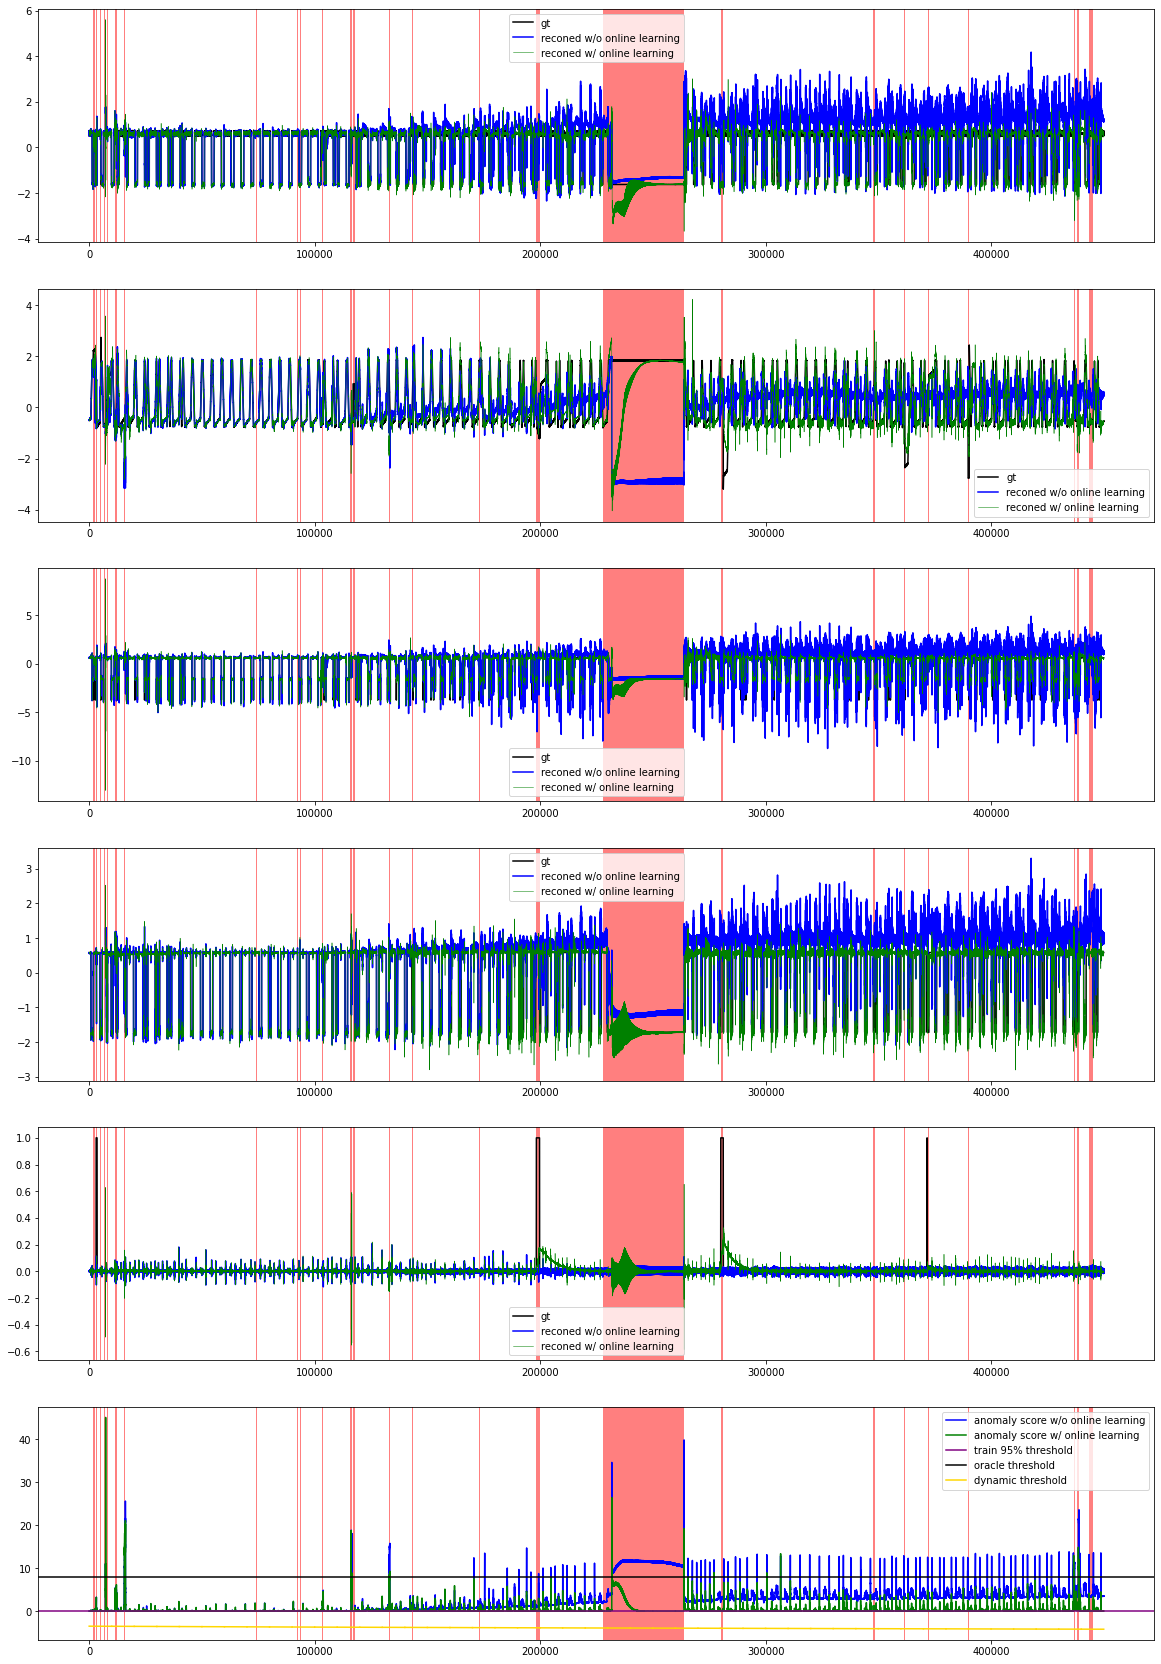

In [55]:
# plot abnormal
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape

fig, ax = plt.subplots(6, 1, figsize=(20, 30))

for c in range(min(args.num_channels, 5)):
    # gt
    ax[c].plot(test_X[:, c], color="black", label="gt")
    plot_anomaly(ax[c], test_y)
    
    # reconed
    ax[c].plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    ax[c].plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    ax[c].legend()

#ax[5].set_ylim([-1, 20])
ax[5].plot(anoscs_prev.reshape(-1), color="blue", label="anomaly score w/o online learning")
ax[5].plot(anoscs.reshape(-1), color="green", label="anomaly score w/ online learning")
ax[5].axhline(th_q95, color="purple", label="train 95% threshold")
ax[5].axhline(th_best_static, color="black", label="oracle threshold")
ax[5].plot(thrs, color="gold",label="dynamic threshold")
ax[5].legend()
plot_anomaly(ax[5], test_y)

plt.show()

### Label-guided Online learning

In [ ]:
init_thr = torch.quantile(train_error_dist, 0.95).item()
thr = torch.tensor(init_thr, requires_grad=True)
thr

In [ ]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TH_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
anoscs=[]
thrs = []
preds = []
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    Xs.append(X)
    
    # infer
    B, L, C = X.shape
    Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
    Xhats.append(Xhat)
    
    e = F.mse_loss(Xhat, X, reduction='none')
    anosc = e.mean(dim=2)
    anoscs.append(anosc)
    thrs.append(thr.item())
    pred = (anosc > thr)
    preds.append(pred)
    
    # update
    TH_optimizer.zero_grad()
    yhat = torch.sigmoid(anosc-thr)
    yhats.append(yhat)
    cls_loss = bce(yhat, y.float())
    mask = ((y == 0).unsqueeze(2))
    recon_loss = (e*mask).mean()
    loss = cls_loss + recon_loss
    loss.backward()
    TH_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()
yhats = torch.cat(yhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(anoscs, axis=0).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

In [ ]:
print(test_y.shape, preds.shape)
get_summary_stats(test_y, preds)

In [ ]:
# plot abnormal
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape

fig, ax = plt.subplots(6, 1, figsize=(20, 30))

for c in range(min(args.num_channels, 5)):
    # gt
    ax[c].plot(test_X[:, c], color="black", label="gt")
    plot_anomaly(ax[c], test_y)
    
    # reconed
    ax[c].plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    ax[c].plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    ax[c].legend()

#ax[5].set_ylim([-1, 20])
ax[5].plot(anoscs_prev.reshape(-1), color="blue", label="anomaly score w/o online learning")
ax[5].plot(anoscs.reshape(-1), color="green", label="anomaly score w/ online learning")
ax[5].axhline(th_q95, color="purple", label="train 95% threshold")
ax[5].axhline(th_best_static, color="black", label="oracle threshold")
ax[5].plot(thrs, color="gold",label="dynamic threshold")
ax[5].legend()
plot_anomaly(ax[5], test_y)

plt.show()

In [ ]:
c=5
plt.figure(figsize=(20, 6))
plt.title(f"{args.dataset}, channel {c}")
plt.plot(train_X[:, c], label="train", color="#1f77b4")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], label="test", color="#ff7f0e")
lb = np.concatenate([np.zeros(len(train_X)), test_y])
plot_anomaly(plt, lb)
plt.legend()
plt.show()

In [ ]:
c=7
plt.figure(figsize=(20, 6))
#plt.ylim(-6, 6)
plt.title(f"{args.dataset}, channel {c}")

plt.plot(train_X[:, c], label="train", color="#1f77b4")
plt.axhline(train_X[100000:, c].mean(), color = 'r', label="mean of train data")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], label="test", color="#ff7f0e")

lb = np.concatenate([np.zeros(len(train_X)), test_y])
plot_anomaly(plt, lb)
plt.legend()
plt.show()

In [ ]:
C = 7
for c in range(args.num_channels):
    plt.figure(figsize=(20, 6))
    plt.title(f"{args.dataset}, channel {c}, train")
    plt.plot(train_X[:, c], label="train", color="#1f77b4")
    plt.legend()
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.title(f"{args.dataset}, channel {c}, test")
    plt.plot(test_X[:, c], label="test", color="#ff7f0e")
    plot_anomaly(plt, test_y)
    plt.legend()
    plt.show()